<a href="https://colab.research.google.com/github/dpant/TensorFlow/blob/main/Course3-NLP/ClassifyTweetsSentiments-GloveEmbedding300d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
nltk.download('book')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import sklearn

import codecs
from tqdm import tqdm

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Package conll2002 is already up-to-date!
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package dependency_treebank is already up-to-date!
[nltk_data]    | Downloadi

In [53]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv



--2021-07-15 19:51:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   189MB/s    in 1.2s    

2021-07-15 19:51:16 (189 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [54]:
raw = pd.read_csv('/tmp/training_cleaned.csv', header=None)

In [55]:
raw.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Sampling raw dataset

In [56]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [57]:
df = stratified_sample_df(raw, 0, 100000).reset_index(drop=True)
df

,0,1,2,3,4,5
0,0,2233100158,Thu Jun 18 20:50:04 PDT 2009,NO_QUERY,sarasmile13,"@firedancertat she tripped, fell, cut her chin..."
1,0,2052435608,Sat Jun 06 00:43:19 PDT 2009,NO_QUERY,ramsin_taffles,"Wow, I'm feeling unwell today, I think I might..."
2,0,2247185901,Fri Jun 19 18:43:07 PDT 2009,NO_QUERY,Julien_Cassidy,ugh just having a really bad day today forgot...
3,0,1977273377,Sat May 30 20:33:24 PDT 2009,NO_QUERY,soberangelforev,@kirstiealley glad to here you reached your go...
4,0,2249001910,Fri Jun 19 21:32:59 PDT 2009,NO_QUERY,nicolexoxo,my friend just left i had fun tho!
...,...,...,...,...,...,...
199995,4,2062935616,Sun Jun 07 00:47:58 PDT 2009,NO_QUERY,katescobar,@massiecabot http://twitpic.com/6tccq - who's ...
199996,4,1999854582,Mon Jun 01 20:56:50 PDT 2009,NO_QUERY,ashleyrwatts,@LauraLilyan Lol World of Warcraft
199997,4,2181803361,Mon Jun 15 12:19:05 PDT 2009,NO_QUERY,lindsay723,So many great things planned this week. I hope...
199998,4,1971842618,Sat May 30 08:01:04 PDT 2009,NO_QUERY,mikeolbinski,"@nickyvender Hey, while you're up, bake us som..."


## Cleaning dataset

In [58]:
df.rename(columns = {0:'target', 5:'text'}, inplace = True)

In [59]:
df = df.drop([1, 2, 3, 4], axis=1)

In [60]:
df.head()

,target,text
0,0,"@firedancertat she tripped, fell, cut her chin..."
1,0,"Wow, I'm feeling unwell today, I think I might..."
2,0,ugh just having a really bad day today forgot...
3,0,@kirstiealley glad to here you reached your go...
4,0,my friend just left i had fun tho!


## Pre-proccessing text

In [61]:
df_preprocess = df.copy()

In [62]:
tweets = df_preprocess.text.copy()

In [63]:
tweets

0         @firedancertat she tripped, fell, cut her chin...
1         Wow, I'm feeling unwell today, I think I might...
2         ugh just having a really bad day today  forgot...
3         @kirstiealley glad to here you reached your go...
4                       my friend just left  i had fun tho!
                                ...                        
199995    @massiecabot http://twitpic.com/6tccq - who's ...
199996                  @LauraLilyan Lol World of Warcraft 
199997    So many great things planned this week. I hope...
199998    @nickyvender Hey, while you're up, bake us som...
199999    @Lauraleelou in NYC he only sang 5 so it was a...
Name: text, Length: 200000, dtype: object

### Remove hashtags, @ and url

In [64]:
def removeWordWithChar(text, char_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    res = [ele for ele in text if all(ch not in ele for ch in char_list)]
    res = ' '.join(res)
    return res

char_list = ['@', '#', 'http', 'www', '/']

removeWordWithChar(tweets[1], char_list)

"Wow, I'm feeling unwell today, I think I might have to just lie in bed all day, it hurts to sit in my chair my tummy hurtsss"

In [65]:
tweets_cleaned = []
for t in tweets:
    tweets_cleaned.append(removeWordWithChar(t, char_list))

In [66]:
tweets_cleaned[0]

'she tripped, fell, cut her chin. She can tell you. She got really hurt.'

In [67]:
len(tweets_cleaned)

200000

### Tokenize

In [68]:
def tokenize(texts):
    tokenizer = nltk.RegexpTokenizer(r'\w+')

    texts_tokens = []
    for i, val in enumerate(texts):
        text_tokens = tokenizer.tokenize(val.lower())

        for i in range(len(text_tokens) - 1, -1, -1):
            if len(text_tokens[i]) < 4:
                del(text_tokens[i])

        texts_tokens.append(text_tokens)
        
    return texts_tokens

In [69]:
tweets_tokens = tokenize(tweets_cleaned)

tweets_tokens[:]

[['tripped', 'fell', 'chin', 'tell', 'really', 'hurt'],
 ['feeling',
  'unwell',
  'today',
  'think',
  'might',
  'have',
  'just',
  'hurts',
  'chair',
  'tummy',
  'hurtsss'],
 ['just',
  'having',
  'really',
  'today',
  'forgot',
  'work',
  'wrong',
  'uniform',
  'over',
  'bucks',
  'register',
  'fired'],
 ['glad',
  'here',
  'reached',
  'your',
  'goal',
  'money',
  'really',
  'tight',
  'wondering',
  'what',
  'activities',
  'summer',
  'with',
  'kids'],
 ['friend', 'just', 'left'],
 ['hayfever', 'summer', 'killer', 'about', 'sneezes'],
 ['still',
  'trying',
  'over',
  'niley',
  'read',
  'single',
  'gossip',
  'magazine',
  'seeing',
  'something',
  'about'],
 ['surgery', 'left', 'they', 'going', 'open', 'scared'],
 ['carry', 'boxes', 'home', 'bike', 'have', 'make', 'trips'],
 ['lost',
  'followers',
  'today',
  'yikes',
  'guess',
  'know',
  'what',
  'tweet',
  'about',
  'future',
  'love',
  'diet',
  'thebatterysdown',
  'steak'],
 ['question',
  'kevi

### Stopwords

In [70]:
def removeSW(texts_tokens):
    stopWords = set(stopwords.words('english'))
    texts_filtered = []

    for i, val in enumerate(texts_tokens):
        text_filtered = []
        for w in val:
            if w not in stopWords:
                text_filtered.append(w)
        texts_filtered.append(text_filtered)
        
    return texts_filtered

In [71]:
tweets_filtered = removeSW(tweets_tokens)

tweets_filtered[:1]

[['tripped', 'fell', 'chin', 'tell', 'really', 'hurt']]

### Lemma

In [72]:
def lemma(texts_filtered):
    wordnet_lemmatizer = WordNetLemmatizer()
    texts_lem = []

    for i, val in enumerate(texts_filtered):
        text_lem = []
        for word in val:
            text_lem.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        texts_lem.append(text_lem)
    
    return texts_lem

In [73]:
nltk.download('wordnet')

tweets_lem = lemma(tweets_filtered)

tweets_lem[:1]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[['trip', 'fell', 'chin', 'tell', 'really', 'hurt']]

In [74]:
tweets_ready = []
for tweet in tweets_lem:
    string = ' '
    string = string.join(tweet)
    tweets_ready.append(string)

In [75]:
len(tweets_ready)

200000

In [76]:
df_preprocess['tweet'] = tweets_ready
df_preprocess['target'] = df.target.replace(4, 1)

In [77]:
df_preprocess

,target,text,tweet
0,0,"@firedancertat she tripped, fell, cut her chin...",trip fell chin tell really hurt
1,0,"Wow, I'm feeling unwell today, I think I might...",feel unwell today think might hurt chair tummy...
2,0,ugh just having a really bad day today forgot...,really today forget work wrong uniform buck re...
3,0,@kirstiealley glad to here you reached your go...,glad reach goal money really tight wonder acti...
4,0,my friend just left i had fun tho!,friend leave
...,...,...,...
199995,1,@massiecabot http://twitpic.com/6tccq - who's ...,girl haha pretty
199996,1,@LauraLilyan Lol World of Warcraft,world warcraft
199997,1,So many great things planned this week. I hope...,many great things plan week hope time
199998,1,"@nickyvender Hey, while you're up, bake us som...",bake banana bread kid dang good hope sleep


## Word embedding : Glove

In [78]:
# 100d glove model. smaller but gets less accuarcy.
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
#!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt  -O /tmp/glove.6B.100d.txt
#GLOVE_EMB = '/tmp/glove.6B.100d.txt'
#EMBEDDING_DIM = 100


In [79]:
##Glove embedding 300d (More accurate!!!)
!wget --no-check-certificate  https://nlp.stanford.edu/data/glove.42B.300d.zip  -O /tmp/glove.42B.300d.zip
! unzip  /tmp/glove.42B.300d.zip
! mv glove.42B.300d.txt /tmp
GLOVE_EMB = '/tmp/glove.42B.300d.txt'
EMBEDDING_DIM = 300

--2021-07-15 19:51:30--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2021-07-15 19:51:31--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Saving to: ‘/tmp/glove.42B.300d.zip’

/tmp/glove.42B.300d 100%[===================>]   1.75G  5.35MB/s    in 5m 55s  

2021-07-15 19:57:26 (5.04 MB/s) - ‘/tmp/glove.42B.300d.zip’ saved [1877800501/1877800501]

Archive:  /tmp/glove.42B.300d.zip
  inflating: glove.42B.300d.txt    

In [80]:
%%time
embeddings_index = {}
f = codecs.open(GLOVE_EMB, encoding='utf-8')
for line in tqdm(f):
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

1917494it [03:19, 9622.60it/s]

Found 1917494 word vectors.
CPU times: user 3min 12s, sys: 8.62 s, total: 3min 21s
Wall time: 3min 19s


In [81]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocess.tweet)

word_index = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocabulary_size)

Vocabulary Size : 66460


In [82]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [83]:
embedding_matrix.shape

(66460, 300)

## Prepare training

In [84]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [85]:
BATCH_SIZE = 1024
EPOCHS = 30

### Create train / test sets

In [86]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_preprocess['tweet'], df_preprocess['target'], test_size=0.2, random_state=123)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 160000
Test Data size 40000


In [87]:
MAX_SEQUENCE_LENGTH = 30

In [88]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (160000, 30)
Testing X Shape: (40000, 30)


### Embedding layer

In [89]:
embedding_matrix.shape

(66460, 300)

In [90]:
embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

### Callbacks

In [91]:
es=EarlyStopping(monitor='val_loss',
                 mode='min',
                 verbose=1,
                 patience=5)

reduce_lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

## Model A : CNN

In [92]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer(inputs)
x = Dropout(0.5)(x)

# Conv1D x2 + global max pooling
x = Conv1D(128, 7, activation="relu")(x)
x = Conv1D(128, 7, activation="relu")(x)
x = GlobalMaxPooling1D()(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_A = tf.keras.Model(inputs, outputs)

In [93]:
model_A.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           19938000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 300)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 128)           268928    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 18, 128)           114816    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               6604

In [94]:
model_A.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [95]:
%%time
history_A = model_A.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 5s 23ms/step - loss: 0.5898 - accuracy: 0.6791 - val_loss: 0.5408 - val_accuracy: 0.7274
Epoch 2/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5530 - accuracy: 0.7121 - val_loss: 0.5256 - val_accuracy: 0.7349
Epoch 3/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5406 - accuracy: 0.7221 - val_loss: 0.5186 - val_accuracy: 0.7420
Epoch 4/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5294 - accuracy: 0.7327 - val_loss: 0.5160 - val_accuracy: 0.7417
Epoch 5/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5213 - accuracy: 0.7382 - val_loss: 0.5121 - val_accuracy: 0.7448
Epoch 6/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5114 - accuracy: 0.7454 - val_loss: 0.5102 - val_accuracy: 0.7490
Epoch 7/30
157/157 [==============================] - 4s 23ms/step - loss: 0.5045 - accuracy: 0.7490 - val_loss: 0.5091 - val_accuracy: 0.7478

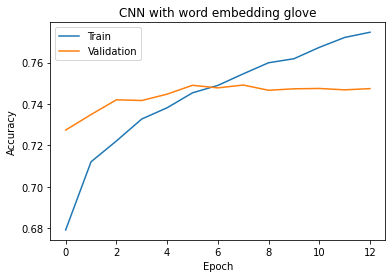

In [96]:
plt.plot(history_A.history['accuracy'])
plt.plot(history_A.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('CNN with word embedding glove')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

## Model B : RNN

In [97]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer(inputs)
x = SpatialDropout1D(0.2)(x)

# Conv1D + LSTM (bidirectional)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_B = tf.keras.Model(inputs, outputs)

In [98]:
model_B.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           19938000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0   

In [99]:
model_B.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [100]:
%%time
history_B = model_B.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 45s 258ms/step - loss: 0.5725 - accuracy: 0.6981 - val_loss: 0.5322 - val_accuracy: 0.7336
Epoch 2/30
157/157 [==============================] - 42s 268ms/step - loss: 0.5334 - accuracy: 0.7299 - val_loss: 0.5184 - val_accuracy: 0.7420
Epoch 3/30
157/157 [==============================] - 41s 259ms/step - loss: 0.5172 - accuracy: 0.7412 - val_loss: 0.5134 - val_accuracy: 0.7437
Epoch 4/30
157/157 [==============================] - 42s 268ms/step - loss: 0.5063 - accuracy: 0.7495 - val_loss: 0.5115 - val_accuracy: 0.7459
Epoch 5/30
157/157 [==============================] - 40s 255ms/step - loss: 0.4954 - accuracy: 0.7569 - val_loss: 0.5108 - val_accuracy: 0.7478
Epoch 6/30
157/157 [==============================] - 41s 263ms/step - loss: 0.4843 - accuracy: 0.7645 - val_loss: 0.5097 - val_accuracy: 0.7495
Epoch 7/30
157/157 [==============================] - 40s 257ms/step - loss: 0.4755 - accuracy: 0.7709 - val_loss: 0.5116 - val_ac

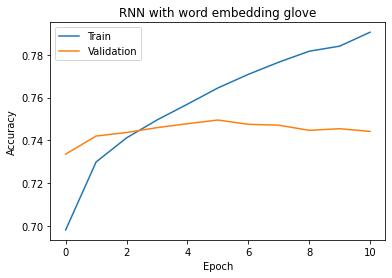

In [101]:
plt.plot(history_B.history['accuracy'])
plt.plot(history_B.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('RNN with word embedding glove')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')